In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import random
from sklearn.metrics import auc
from sklearn.preprocessing import StandardScaler

In [2]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'

In [3]:
!wget $data -O bank_marketing_data.csv 

--2025-10-16 12:45:14--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘bank_marketing_data.csv’

bank_marketing_data 100%[===================>]  78.98K  --.-KB/s    in 0.08s   

2025-10-16 12:45:15 (1.01 MB/s) - ‘bank_marketing_data.csv’ saved [80876/80876]



In [4]:
df = pd.read_csv('bank_marketing_data.csv')
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


# Data Preparation

In [5]:
categorical = ['lead_source', 'industry', 'employment_status', 'location']
numerical = ['number_of_courses_viewed', 'annual_income', 'lead_score', 'interaction_count']

In [6]:
for c in categorical:
    df[c] = df[c].fillna('NA')
df['annual_income'] = df['annual_income'].fillna(0.0)    

In [7]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
print(len(df), len(df_full_train), len(df_test))

df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
print(len(df_train), len(df_val))

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

1462 1169 293
876 293


# Question 1: ROC AUC feature importance
ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
Use the training dataset for that
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['balance'])

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- lead_score
- number_of_courses_viewed
- interaction_count
- annual_income

In [8]:
for feature in numerical:
    predictions = df_train[feature].values
    auc = roc_auc_score(y_train, predictions)

    if auc < 0.5:
        auc = roc_auc_score(y_train, -predictions)
        print(f'{feature}: AUC = {auc:.4f} (inverted)')
    else:
        print(f'{feature}: AUC = {auc:.4f}')

number_of_courses_viewed: AUC = 0.7636
annual_income: AUC = 0.5520
lead_score: AUC = 0.6145
interaction_count: AUC = 0.7383


# Question 2: Training the model
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

In [9]:
scaler = StandardScaler()

In [10]:
def train(df_train, y_train, C=1.0):
    train_dicts = df_train[categorical + numerical].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    
    X_train = dv.fit_transform(train_dicts)
    X_train = scaler.fit_transform(X_train)
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

In [11]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    X = scaler.transform(X)

    y_pred = model.predict_proba(X)[:, 1]
    return y_pred

In [12]:
dv, model = train(df_train, y_train)
y_pred = predict(df_val, dv, model)
auc = roc_auc_score(y_val, y_pred)
print(round(auc, 3))

0.921



# Question 3: Precision and Recall
Now let's compute precision and recall for our model.

- Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them
  
At which threshold precision and recall curves intersect?

- 0.145
- 0.345
- 0.545
- 0.745

# Question 4: F1 score
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.14
- 0.34
- 0.54
- 0.74

In [13]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)
    
    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)
    
        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)
    
        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
    
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))
        
    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)   

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
    df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)

    df_scores['f1_score'] = 2 * ((df_scores.precision) * (df_scores.recall)) / ((df_scores.precision) + (df_scores.recall))

    return df_scores

In [14]:
df_values = tpr_fpr_dataframe(y_val, y_pred)
df_values.iloc[::10]

,threshold,tp,fp,fn,tn,tpr,fpr,precision,recall,f1_score
0,0.0,171,122,0,0,1.000000,1.000000,0.583618,1.000000,0.737069
10,0.1,168,92,3,30,0.982456,0.754098,0.646154,0.982456,0.779582
20,0.2,165,63,6,59,0.964912,0.516393,0.723684,0.964912,0.827068
30,0.3,163,48,8,74,0.953216,0.393443,0.772512,0.953216,0.853403
40,0.4,156,33,15,89,0.912281,0.270492,0.825397,0.912281,0.866667
50,0.5,152,26,19,96,0.888889,0.213115,0.853933,0.888889,0.871060
60,0.6,142,16,29,106,0.830409,0.131148,0.898734,0.830409,0.863222
70,0.7,136,10,35,112,0.795322,0.081967,0.931507,0.795322,0.858044
80,0.8,128,7,43,115,0.748538,0.057377,0.948148,0.748538,0.836601
90,0.9,99,5,72,117,0.578947,0.040984,0.951923,0.578947,0.720000


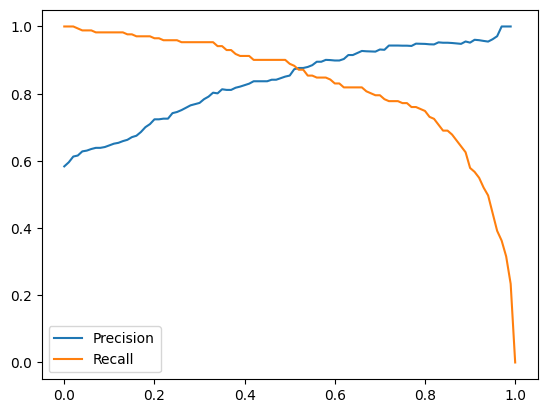

In [15]:
plt.plot(df_values['threshold'], df_values['precision'], label='Precision')
plt.plot(df_values['threshold'], df_values['recall'], label='Recall')
plt.legend()
plt.show()

In [16]:
# Find intersection point
df_values['diff'] = np.abs(df_values['precision'] - df_values['recall'])
intersection_idx = df_values['diff'].idxmin()
intersection_threshold = df_values.loc[intersection_idx, 'threshold']

print(f"Threshold at intersection: {intersection_threshold:.3f}")
print(f"Precision at intersection: {df_values.loc[intersection_idx, 'precision']:.3f}")
print(f"Recall at intersection: {df_values.loc[intersection_idx, 'recall']:.3f}")

# You can also look at a few rows around the intersection
print("\nRows around intersection:")
print(df_values.iloc[intersection_idx-2:intersection_idx+3][['threshold', 'precision', 'recall', 'diff']])

Threshold at intersection: 0.520
Precision at intersection: 0.876
Recall at intersection: 0.871

Rows around intersection:
    threshold  precision    recall      diff
50       0.50   0.853933  0.888889  0.034956
51       0.51   0.872832  0.883041  0.010209
52       0.52   0.876471  0.871345  0.005126
53       0.53   0.876471  0.871345  0.005126
54       0.54   0.879518  0.853801  0.025717


In [17]:
max_idx = df_values['f1_score'].idxmax()
print(max_idx)
df_values.iloc[max_idx]

51


threshold      0.510000
tp           151.000000
fp            22.000000
fn            20.000000
tn           100.000000
tpr            0.883041
fpr            0.180328
precision      0.872832
recall         0.883041
f1_score       0.877907
diff           0.010209
Name: 51, dtype: float64

# Question 5: 5-Fold CV
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)

- Iterate over different folds of df_full_train
- Split the data into train and validation
- Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
- Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.36

In [18]:
!pip install tqdm


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [19]:
from tqdm.auto import tqdm

In [20]:
n_splits = 5

scores = []
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    y_train = df_full_train['converted'].iloc[train_idx].values
    y_val = df_full_train['converted'].iloc[val_idx].values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
    print(f'Fold {len(scores)}: AUC = {auc:.3f}')

    print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))     

Fold 1: AUC = 0.921
0.921 +- 0.000
Fold 2: AUC = 0.932
0.926 +- 0.005
Fold 3: AUC = 0.906
0.920 +- 0.011
Fold 4: AUC = 0.910
0.917 +- 0.010
Fold 5: AUC = 0.931
0.920 +- 0.010


In [21]:
print(f'\nAll scores: {[round(s, 3) for s in scores]}')
print(f'Mean AUC: {np.mean(scores):.3f}')
print(f'Standard deviation: {np.std(scores):.3f}')


All scores: [0.921, 0.932, 0.906, 0.91, 0.931]
Mean AUC: 0.920
Standard deviation: 0.010


# Question 6: Hyperparameter Tuning
Now let's use 5-Fold cross-validation to find the best parameter C

- Iterate over the following C values: [0.000001, 0.001, 1]
- Initialize KFold with the same parameters as previously
- Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
- Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

- 0.000001
- 0.001
- 1

In [22]:
n_splits = 5

for C in tqdm([0.000001, 0.001, 1]):

    scores = []
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
        y_train = df_full_train['converted'].iloc[train_idx].values
        y_val = df_full_train['converted'].iloc[val_idx].values
    
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
        print(f'Fold {len(scores)}: AUC = {auc:.3f}')
    
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))  

  0%|          | 0/3 [00:00<?, ?it/s]

Fold 1: AUC = 0.906
Fold 2: AUC = 0.916
Fold 3: AUC = 0.891
Fold 4: AUC = 0.910
Fold 5: AUC = 0.912
C=1e-06 0.907 +- 0.009
Fold 1: AUC = 0.911
Fold 2: AUC = 0.920
Fold 3: AUC = 0.895
Fold 4: AUC = 0.914
Fold 5: AUC = 0.916
C=0.001 0.911 +- 0.009
Fold 1: AUC = 0.921
Fold 2: AUC = 0.932
Fold 3: AUC = 0.906
Fold 4: AUC = 0.910
Fold 5: AUC = 0.931
C=1 0.920 +- 0.010
